**The Black-Scholes Differential Equation**

$$\frac{\partial C}{\partial T} + \frac{1}{2}\sigma^2S^2\frac{\partial ^2C}{\partial S^2} + rS\frac{\partial C}{\partial S} - rC = 0 $$

**Boundary Condition**

- European Call Option:
$$ C(T) = max(S_T-K,0)$$
- European Put Option:
$$ P(T) = max(K - S_T, 0) $$

**Solutions**

Formulae for the prices of European Call and Put options at a time t:
$$
c(t) = (S(t) \cdot N(d_1)) - (K \cdot e^{-r(T- t)} \cdot N(d_2)) 
$$
$$
p(t) = (K \cdot e^{-r(T- t)} \cdot N(-d_2)) - (S(t) \cdot N(-d_1))
$$
where,
$$
d_1 = \frac{\ln\left(\frac{S(t)}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T -t}}
$$
$$
d_2 = d_1 - \sigma\sqrt{T -t}
$$


Import Packages

In [80]:
import yfinance as yf
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [81]:
def black_scholes_analytical(S, K, T, r, sigma, t, type='C'):
    
    d1 = (math.log(S / K) + ((r + (0.5 * (sigma ** 2))) * (T - t))) / (sigma * math.sqrt(T - t))
    d2 = d1 - (sigma * math.sqrt(T - t))
    
    if type == 'C':
        N_d1 = norm.cdf(d1,0,1)
        N_d2 = norm.cdf(d2,0,1)
        
        val = (S * N_d1) - ((K * math.exp(-r * (T- t))) * N_d2)
        
    elif type == 'P':
        N_d1 = norm.cdf(-d1,0,1)
        N_d2 = norm.cdf(-d2,0,1)
        
        val = ((K * math.exp(-r * (T- t))) * N_d2) - (S * N_d1)
        
    else:
        raise ValueError('Wrong input for type')
    
    return val    

In [82]:
S_0 = 100
K = 100
r = .04
sigma = .30
T = 1
t = 0

call = black_scholes_analytical(S_0, K, T, r, sigma, t, type='C')
put = black_scholes_analytical(S_0, K, T, r, sigma, t, type='P')

print(f'Call Price: ${round(call, 2)}\nPut Price: ${round(put, 2)}')

Call Price: $13.75
Put Price: $9.83


Historical Data

In [83]:
df= yf.download("AAPL", period= "2y", auto_adjust=False)['Close']

[*********************100%***********************]  1 of 1 completed


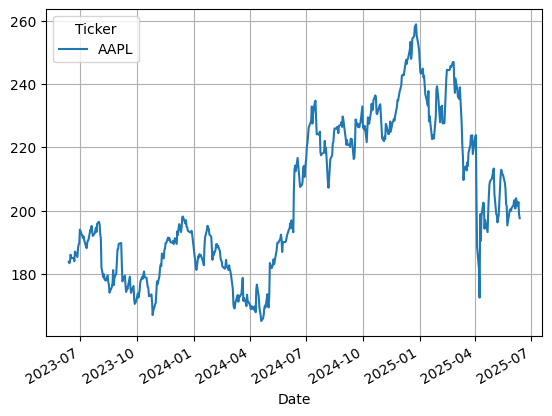

In [84]:
df.plot()
plt.grid();

**Stock Price Dynamics**

Follows Geometric Brownian Motion

$$
dS(t) = \mu S(t)dt + \mu S(t)dW(t)
$$

Closed form solution:

$$
S(t) = S_0e^{(\mu - \frac{1}{2}\sigma^2)t + \sigma W(t)}
$$

In [85]:
def gbm(n_sims, N, T, r, sigma, S_0):
    """
    Simulate Stock Prices using Geometric Brownian Motion Model

    Args:
        n_sims (_type_): Number of Simulations
        N (_type_): Time Steps
        T (_type_): Time to Maturity
        r (_type_): Risk-Free rate
        sigma (_type_): Volatility
        S_0 (_type_): Initial Stock Price
        
    Returns a dataframe of simulated stock paths
    """
    
    Z = np.random.normal(0,1,[n_sims, N])
    X = np.zeros([n_sims, N + 1])
    W = np.zeros([n_sims, N + 1])
    time = np.zeros([N + 1])
    X[:,0] = np.log(S_0)
    dt = T / float(N)
    
    for i in range(0, N):
        W[:, i + 1] = W[:, i] + np.power(dt, .5) * Z[:, i]
        X[:, i + 1] = X[:, i] + ((r - (.5 * (sigma ** 2))) * dt) + (sigma * (W[:, i + 1] - W[:, i]))
        time[i+1] = time[i] + dt
        
    S = np.exp(X)
    paths = pd.DataFrame(S.T, index= time)
    return paths

In [86]:
returns = df.pct_change().dropna()

mu = float(returns.mean().values[0])
sigma = float(returns.std().values[0])
n_sims = 70
T = 1
N = 252
S_0 = df.iloc[-1].values[0]
S_0 = float(S_0)


In [87]:
paths = gbm(n_sims, N, T, r, sigma, S_0)

In [88]:
sims_average = paths.mean(axis=1).to_frame()
sims_average.columns = ['Expected Prices']

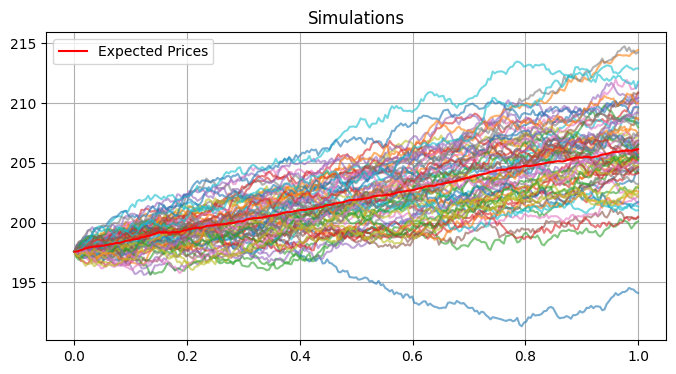

In [89]:
ax = paths.plot(alpha=.6, legend = False, title = 'Simulations')
sims_average.plot(ax =ax, color=['red'], figsize=(8,4))
plt.grid()
plt.show()

In [92]:
time = np.array(paths.index)
K = 180

S = paths.mean(axis=1).values

call = black_scholes_analytical(S[0], K, T, mu, sigma, time[0], type='C')
put = black_scholes_analytical(S[0], K, T, mu, sigma, time[0], type='P')

call, put

(np.float64(17.6274168182037), np.float64(1.7926191469381722e-08))

In [93]:
call_prices = []
put_prices = []

for i in range(len(time)):
    call = black_scholes_analytical(S[i], K, T, mu, sigma, time[i], type='C')
    put = black_scholes_analytical(S[i], K, T, mu, sigma, time[i], type='P')
    
    call_prices.append(call)
    put_prices.append(put)
    
data = {'S(t)': S, 'call': call_prices, 'put': put_prices}

table = pd.DataFrame(data, index=time)
table


,S(t),call,put
0.000000,197.574905,17.627417,1.792619e-08
0.003968,197.587640,17.639943,1.646492e-08
0.007937,197.646924,17.699019,1.396440e-08
0.011905,197.707749,17.759635,1.179458e-08
0.015873,197.769546,17.821224,9.929666e-09
...,...,...,...
0.984127,206.029860,26.030694,0.000000e+00
0.988095,206.013372,26.013997,0.000000e+00
0.992063,206.068361,26.068778,0.000000e+00
0.996032,206.090966,26.091174,0.000000e+00
